[EP08] 영화리뷰 텍스트 감성분석하기

<<목차>>

1) 데이터 준비와 확인
2) 데이터로더 구성
3) 모델 구성을 위한 데이터 분석 및 가공
4) 모델 구성 및 validation set 구성
5) 모델 훈련 개시
6) Loss, Accuracy 그래프 시각화
7) 학습된 Embedding 레이어 분석
8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
9) 루브릭
10) 회고

1) 데이터 준비와 확인

In [23]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import gensim

from konlpy.tag import Okt, Mecab
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant


In [24]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/movie_review/ratings_train.txt')
test_data = pd.read_table('~/movie_review/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성

In [25]:
# 중복하지 않은 데이터의 개수
train_data[['document', 'label']].nunique()

document    146182
label            2
dtype: int64

In [26]:
# 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

train_data[:5]

/tmp/ipykernel_5962/215865904.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [27]:
# train_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

# 다시 한 번 Null 값이 존재하는지 확인
train_data.isnull().sum()

id            0
document    694
label         0
dtype: int64

In [28]:
# Null 값이 있는 행 10개만 출력
train_data.loc[train_data.document.isnull()][:10]

,id,document,label
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2648,423224,NaN,1
2834,3645129,NaN,0
2867,9197016,NaN,1
2968,7957379,NaN,1
3692,2192935,NaN,0
3887,6959675,NaN,1


In [29]:
# NaN은 아무런 의미가 없는 데이터 이므로 제거
train_data = train_data.dropna(how = 'any')

print('전처리 후 학습용 데이터 개수 :', len(train_data))

전처리 후 학습용 데이터 개수 : 149306


In [30]:
# 테스트 데이터도 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")
# test_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)
# NaN은 아무런 의미가 없는 데이터 이므로 제거
test_data = test_data.dropna(how = 'any')

print('전처리 후 테스트용 데이터 개수 :', len(test_data))

전처리 후 테스트용 데이터 개수 : 49773


/tmp/ipykernel_5962/2423763838.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")


In [31]:
tokenizer = Mecab()

# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 학습용 데이터에서 document 열에서 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 학습용 데이터에서 Null 값이 존재하는 행 제거
    train_data = train_data.dropna(how = 'any') 
    # 테스트용 데이터에서 document 열에서 중복 데이터 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 테스트용 데이터에서 Null 값이 존재하는 행 제거
    test_data = test_data.dropna(how = 'any') 
    
    # 한국어 토크나이저로 토큰화 및 불용어 제거
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 형태소 단위로 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) 
        temp_x = [word for word in temp_x if not word in stopwords] 
        x_test.append(temp_x)

    # 사전 작성
    words = np.concatenate(x_train).tolist()   # .tolist() : array를 list로 변경
    counter = Counter(words)                   # collection 모듈의 Counter 클래스로 데이터의 개수 확인
    counter = counter.most_common(10000-4)     # most_common() : 데이터의 개수가 많은 순으로 정렬된 배열 리턴
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # word_to_index
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        # wordlist에 있는 word에 대해서 만약에 word가 word_to_index에 존재하면 인덱스 값을, 존재하지 않으면 <UNK>를 인덱스로 반환함

    x_train = list(map(wordlist_to_indexlist, x_train))   # x_train 대상으로 wordlist_to_indexlist 함수를 수행하여 리스트로 반환
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [32]:
print("훈련 데이터 개수: {},  테스트 데이터 개수: {}".format(len(x_train), len(x_test)))

훈련 데이터 개수: 143856,  테스트 데이터 개수: 48498


In [33]:
# key= index, value= word로 변경
index_to_word = {index:word for word, index in word_to_index.items()}

In [34]:
# 활용할 딕셔너리와 함께 문장 1개를 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

In [35]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.105529388523244
문장길이 최대 :  84
문장길이 표준편차 :  11.58677388511839


/home/june/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

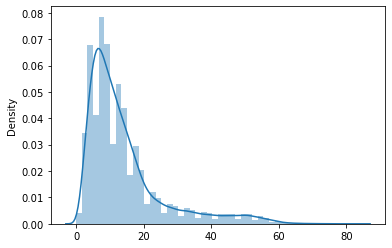

In [36]:
# 문장 길이 분포 시각화
sns.distplot(num_tokens)

In [37]:
# 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

pad_sequences maxlen :  48
전체 문장의 97.04867068010023%가 maxlen 설정값 이내에 포함됩니다. 


In [38]:
# 문장의 길이가 maxlen 보다 짧은 문장에 <PAD>를 앞부분에 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print('shape of x_train : ', x_train.shape)
print('shape of x_test : ', x_test.shape)

shape of x_train :  (143856, 48)
shape of x_test :  (48498, 48)


4) 모델 구성 및 validation set 구성

In [39]:
# train data set에서 80:20의 비율로 train과 validation으로 분리, RNN에서는 순서가 중요하므로 shuffle은 진행하지 않도록 한다.
# train set
partial_x_train = x_train[:int(x_train.shape[0]*0.8)]
partial_y_train = y_train[:int(y_train.shape[0]*0.8)]

# validation set
x_valid = x_train[int(x_train.shape[0]*0.8):]
y_valid = y_train[int(x_train.shape[0]*0.8):]

print('partial_x_train :', partial_x_train.shape)
print('partial_y_train :', partial_y_train.shape)
print('x_valid :', x_valid.shape)
print('y_valid :', y_valid.shape)

partial_x_train : (115084, 48)
partial_y_train : (115084,)
x_valid : (28772, 48)
y_valid : (28772,)


5) 모델 훈련 개시

In [40]:
##RNN##

vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원 

RNNmodel1 = keras.Sequential()
RNNmodel1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# RNNmodel1.add(keras.layers.LSTM(128))                        #  RNN에서 가장 널리 사용하는 LSTM 레이어 사용
RNNmodel1.add(keras.layers.GRU(128))                            # LSTM 모델을 발전 시킨 모델
RNNmodel1.add(keras.layers.Dense(16, activation='relu'))
RNNmodel1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 

RNNmodel1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 gru (GRU)                   (None, 128)               126720    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,128,801
Trainable params: 2,128,801
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 학습 환경 설정
RNNmodel1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = RNNmodel1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/10
450/450 [==============================] - 5s 8ms/step - loss: 0.3916 - accuracy: 0.8209 - val_loss: 0.3371 - val_accuracy: 0.8531
Epoch 2/10
450/450 [==============================] - 3s 7ms/step - loss: 0.3005 - accuracy: 0.8709 - val_loss: 0.3316 - val_accuracy: 0.8557
Epoch 3/10
450/450 [==============================] - 3s 7ms/step - loss: 0.2598 - accuracy: 0.8893 - val_loss: 0.3370 - val_accuracy: 0.8543
Epoch 4/10
450/450 [==============================] - 3s 8ms/step - loss: 0.2290 - accuracy: 0.9039 - val_loss: 0.3563 - val_accuracy: 0.8532
Epoch 5/10
450/450 [==============================] - 3s 8ms/step - loss: 0.2007 - accuracy: 0.9163 - val_loss: 0.3878 - val_accuracy: 0.8512
Epoch 6/10
450/450 [==============================] - 3s 7ms/step - loss: 0.1726 - accuracy: 0.9286 - val_loss: 0.4351 - val_accuracy: 0.8496
Epoch 7/10
450/450 [==============================] - 3s 8ms/step - loss: 0.1472 - accuracy: 0.9389 - val_loss: 0.4900 - val_accuracy: 0.8472
Epoch 

6) Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


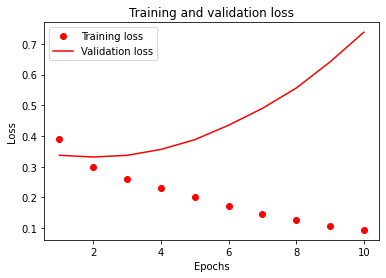

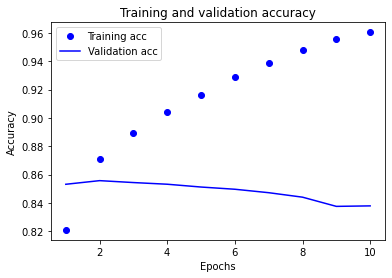

In [42]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
# test 결과
results = RNNmodel1.evaluate(x_test, y_test, verbose=2)

print(results)

1516/1516 - 4s - loss: 0.7099 - accuracy: 0.8421 - 4s/epoch - 3ms/step
[0.7098637819290161, 0.8420965671539307]


7) 학습된 Embedding 레이어 분석

In [44]:
embedding_layer = RNNmodel1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [45]:
word2vec_file_path = '/home/june/movie_review/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = RNNmodel1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-6.29072189e-02, -1.39242234e-02,  2.99953332e-04,  3.19971368e-02,
        4.40031812e-02,  8.31831433e-03,  2.42975950e-02,  8.29617530e-02,
       -2.60638185e-02, -4.76677790e-02, -3.43544222e-02,  3.88854109e-02,
        4.81487289e-02, -5.60402032e-03, -4.40733880e-02, -2.95892637e-02,
       -8.55856165e-02,  1.02371047e-03, -3.60028557e-02, -2.82874797e-02,
        1.95963662e-02, -8.08622502e-03, -1.81090273e-02, -2.22242028e-02,
        2.55763195e-02,  2.96708811e-02,  1.60585660e-02, -9.18463431e-03,
        4.45711464e-02,  2.62844414e-02,  4.28804457e-02,  8.70348979e-03,
       -2.85525452e-02, -1.02823293e-02, -1.03872336e-01, -5.40985540e-02,
        4.83282469e-03, -2.38753902e-03,  2.35170908e-02,  3.46691953e-03,
       -1.16564604e-02,  2.84499601e-02, -1.20280413e-02, -6.89675892e-03,
       -1.55896908e-02,  1.32625541e-02,  3.88897359e-02, -1.29093686e-02,
       -2.04137508e-02, -4.39422019e-02, -8.11789557e-02,  4.19983193e-02,
        1.01577975e-02, -

In [47]:
word_vectors.similar_by_word("영화")

[('들어간다', 0.5246351957321167),
 ('오', 0.5111040472984314),
 ('더라고요', 0.5109429359436035),
 ('작품', 0.5107095241546631),
 ('점', 0.5087099075317383),
 ('천국', 0.5041117072105408),
 ('흡사', 0.49011844396591187),
 ('능가', 0.4839653968811035),
 ('을려나', 0.480087012052536),
 ('꾼', 0.4773670732975006)]

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [48]:
from gensim.models import Word2Vec

word2vec_path = '/home/june/movie_review/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [49]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("영화")

[('들어간다', 0.5246351957321167),
 ('오', 0.5111040472984314),
 ('더라고요', 0.5109429359436035),
 ('작품', 0.5107095241546631),
 ('점', 0.5087099075317383),
 ('천국', 0.5041117072105408),
 ('흡사', 0.49011844396591187),
 ('능가', 0.4839653968811035),
 ('을려나', 0.480087012052536),
 ('꾼', 0.4773670732975006)]

In [50]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] == word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

RNNmodel2_ko = keras.Sequential()
RNNmodel2_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
RNNmodel2_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
RNNmodel2_ko.add(keras.layers.MaxPooling1D(5))
RNNmodel2_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
RNNmodel2_ko.add(keras.layers.GlobalMaxPooling1D())
RNNmodel2_ko.add(keras.layers.Dense(128, activation='relu'))
RNNmodel2_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [51]:
RNNmodel2_ko.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 48, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 42, 64)            89664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             28736     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 128)              

In [52]:
RNNmodel2_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = RNNmodel2_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/10
450/450 [==============================] - 4s 6ms/step - loss: 0.6187 - accuracy: 0.6115 - val_loss: 0.4675 - val_accuracy: 0.7752
Epoch 2/10
450/450 [==============================] - 3s 6ms/step - loss: 0.4263 - accuracy: 0.7991 - val_loss: 0.4257 - val_accuracy: 0.7971
Epoch 3/10
450/450 [==============================] - 3s 6ms/step - loss: 0.3815 - accuracy: 0.8243 - val_loss: 0.4238 - val_accuracy: 0.8026
Epoch 4/10
450/450 [==============================] - 3s 6ms/step - loss: 0.3557 - accuracy: 0.8391 - val_loss: 0.4254 - val_accuracy: 0.8023
Epoch 5/10
450/450 [==============================] - 3s 6ms/step - loss: 0.3249 - accuracy: 0.8562 - val_loss: 0.4469 - val_accuracy: 0.7961
Epoch 6/10
450/450 [==============================] - 3s 6ms/step - loss: 0.2975 - accuracy: 0.8710 - val_loss: 0.4686 - val_accuracy: 0.7920
Epoch 7/10
450/450 [==============================] - 3s 6ms/step - loss: 0.2639 - accuracy: 0.8878 - val_loss: 0.5029 - val_accuracy: 0.7901
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


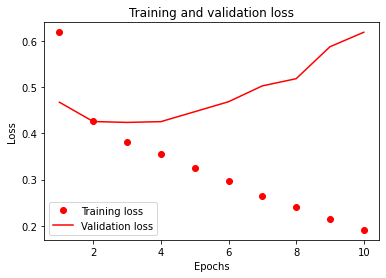

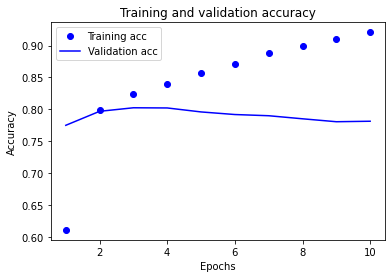

In [53]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
# 테스트셋을 통한 모델 평가
results = RNNmodel2_ko.evaluate(x_test,  y_test, verbose=2)

print(results)

1516/1516 - 3s - loss: 0.6283 - accuracy: 0.7779 - 3s/epoch - 2ms/step
[0.6282691955566406, 0.7778671383857727]


★다양한 모델

In [55]:
vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))
conv1d_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          28736     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          28736     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 128)              

In [56]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.4392 - accuracy: 0.7836 - val_loss: 0.3959 - val_accuracy: 0.8133
Epoch 2/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.3385 - accuracy: 0.8440 - val_loss: 0.4022 - val_accuracy: 0.8153
Epoch 3/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.2566 - accuracy: 0.8843 - val_loss: 0.4626 - val_accuracy: 0.8048
Epoch 4/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.1893 - accuracy: 0.9143 - val_loss: 0.5617 - val_accuracy: 0.7980
Epoch 5/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.1486 - accuracy: 0.9315 - val_loss: 0.6426 - val_accuracy: 0.7998
Epoch 6/10
3597/3597 [==============================] - 17s 5ms/step - loss: 0.1238 - accuracy: 0.9420 - val_loss: 0.7063 - val_accuracy: 0.7915
Epoch 7/10
3597/3597 [==============================] - 18s 5ms/step - loss: 0.1078 - accuracy: 0.9478 - val_loss: 0.8191 - val_ac

In [57]:
results = conv1d_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1516/1516 - 3s - loss: 1.0496 - accuracy: 0.7850 - 3s/epoch - 2ms/step
[1.049578309059143, 0.7849602103233337]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


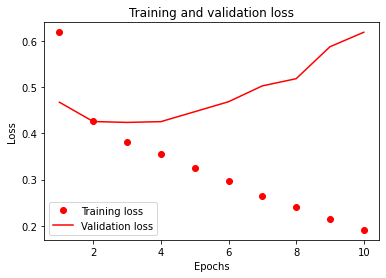

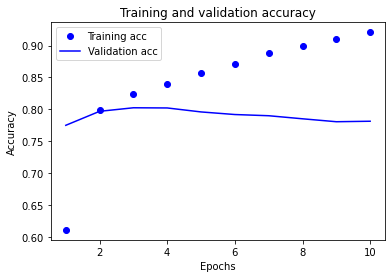

In [58]:
## Loss, Accuracy 그래프 시각화

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [59]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [60]:
word2vec_file_path = '/home/june/movie_review/word2vec_ko2.model'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['악당']
vector

array([ 0.04925826,  0.20526172, -0.09151779,  0.13736813, -0.02199855,
       -0.05165334, -0.2956065 , -0.02144566,  0.07739383, -0.12475446,
       -0.02547732,  0.014899  , -0.03831469, -0.05243574, -0.1399936 ,
        0.02146734, -0.0979605 , -0.2817227 , -0.01906992, -0.07673535,
        0.18999399, -0.1047303 ,  0.07731375,  0.04711425,  0.06015249,
       -0.11158656, -0.03391605, -0.0636792 , -0.38536134, -0.03318309,
        0.07347295,  0.15344568,  0.15033253, -0.10628718, -0.10055444,
       -0.00141014,  0.07986456, -0.0113338 , -0.1778345 ,  0.08497158,
       -0.04459934, -0.07761587,  0.3251365 , -0.24583146,  0.04293126,
        0.27703565, -0.04164285, -0.08604749,  0.17587495,  0.25815108,
       -0.02728944, -0.01662206, -0.14649576,  0.22877972,  0.11900971,
        0.07347644,  0.08527268, -0.21412112, -0.11178777,  0.16067353,
       -0.00710672, -0.17157987, -0.22259408, -0.13105953], dtype=float32)

In [61]:
word_vectors.similar_by_word("감동")

[('귀여워', 0.7168909907341003),
 ('웃겨요', 0.6821069121360779),
 ('못할', 0.6751304864883423),
 ('인권', 0.6700026988983154),
 ('멋져', 0.6691322922706604),
 ('명복', 0.6663233637809753),
 ('맛깔', 0.6618707776069641),
 ('관해', 0.659599781036377),
 ('카타르시스', 0.6558892726898193),
 ('굉장', 0.6537660360336304)]

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] == word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [63]:
conv1d_model2 = keras.Sequential()
conv1d_model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
conv1d_model2.add(keras.layers.Conv1D(32, 7, activation='relu'))
conv1d_model2.add(keras.layers.MaxPooling1D(5))
conv1d_model2.add(keras.layers.Conv1D(32, 7, activation='relu'))
conv1d_model2.add(keras.layers.GlobalMaxPooling1D())
conv1d_model2.add(keras.layers.Dense(128, activation='relu'))
conv1d_model2.add(keras.layers.Dense(1, activation='sigmoid')) 

conv1d_model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 48, 200)           2000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 42, 32)            44832     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             7200      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 128)              

In [64]:
conv1d_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20


history = conv1d_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/20
450/450 [==============================] - 3s 6ms/step - loss: 0.6935 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 2/20
450/450 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 3/20
450/450 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 4/20
450/450 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 6/20
450/450 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 7/20
450/450 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5051
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


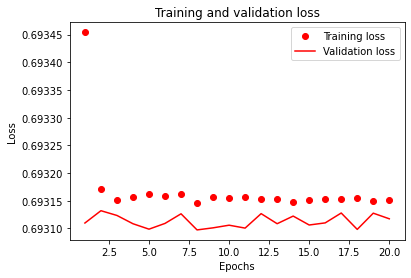

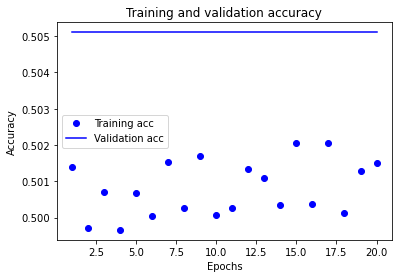

In [65]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [66]:
results = conv1d_model2.evaluate(x_test,  y_test, verbose=2)

print(results)

1516/1516 - 3s - loss: 0.6932 - accuracy: 0.4985 - 3s/epoch - 2ms/step
[0.6931628584861755, 0.4984947741031647]


★다양한 모델 2

In [67]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(64))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))
LSTM_.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,067,905
Trainable params: 2,067,905
Non-trainable params: 0
_________________________________________________________________


In [68]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/10
3594/3597 [============================>.] - ETA: 0s - loss: 0.3690 - accuracy: 0.8348
Epoch 1: saving model to best_model.h5
3597/3597 [==============================] - 23s 6ms/step - loss: 0.3690 - accuracy: 0.8349 - val_loss: 0.3230 - val_accuracy: 0.8600
Epoch 2/10
3596/3597 [============================>.] - ETA: 0s - loss: 0.2804 - accuracy: 0.8799
Epoch 2: saving model to best_model.h5
3597/3597 [==============================] - 21s 6ms/step - loss: 0.2804 - accuracy: 0.8799 - val_loss: 0.3159 - val_accuracy: 0.8657
Epoch 3/10
3588/3597 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.9038
Epoch 3: saving model to best_model.h5
3597/3597 [==============================] - 22s 6ms/step - loss: 0.2319 - accuracy: 0.9037 - val_loss: 0.3295 - val_accuracy: 0.8642
Epoch 4/10
3595/3597 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9233
Epoch 4: saving model to best_model.h5
3597/3597 [==============================] - 21s 6

In [69]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1516/1516 - 4s - loss: 0.5537 - accuracy: 0.8470 - 4s/epoch - 2ms/step
[0.5537224411964417, 0.8470039963722229]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


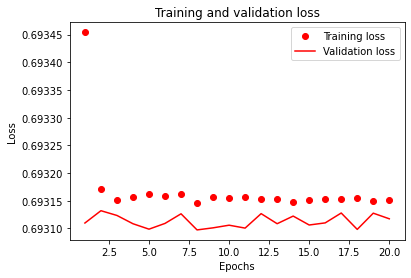

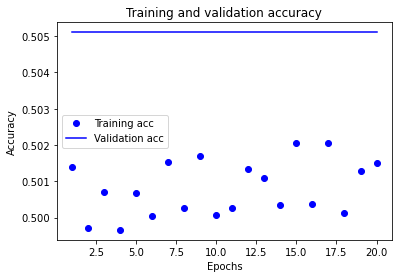

In [70]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [71]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [72]:
word2vec_file_path = '/home/june/movie_review/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [73]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.11528244,  0.20293   ,  0.04355571, -0.22249109, -0.08017095,
        0.02130465,  0.00341184,  0.10134786, -0.04252659,  0.03647081,
        0.05885269,  0.22775984, -0.07320397,  0.05308719, -0.10688861,
        0.04014566,  0.02026018,  0.02022763,  0.02814739, -0.0461684 ,
        0.11153336,  0.05697232,  0.14628601, -0.1194447 , -0.10416766,
       -0.19759493,  0.02113898, -0.05596198, -0.11180481,  0.18370056,
       -0.12978871,  0.05512014,  0.010388  , -0.215866  , -0.20393804,
       -0.08665814,  0.02449067,  0.08449262,  0.019382  ,  0.09389205,
        0.08775812,  0.19736104, -0.10310142,  0.03646832,  0.00125526,
       -0.05529849, -0.20722982, -0.3239285 ,  0.01322813,  0.08218254,
       -0.06320926,  0.21337244, -0.01533518, -0.02599421, -0.10449773,
       -0.08733229, -0.12474084, -0.12559985,  0.15855347,  0.03500714,
        0.09818054,  0.11667581, -0.03595849, -0.0622998 ,  0.1378659 ,
        0.16807248,  0.16985938, -0.02294382, -0.02694793,  0.09

In [74]:
word_vectors.similar_by_word("감동")

[('장엄', 0.8173152804374695),
 ('쿨', 0.7967877388000488),
 ('재해석', 0.7965972423553467),
 ('명작', 0.7889525890350342),
 ('100', 0.7853142619132996),
 ('즐거운', 0.7766128778457642),
 ('꿀', 0.7750331163406372),
 ('기발', 0.7733831405639648),
 ('고발', 0.7684131860733032),
 ('훗', 0.7660568356513977)]

In [75]:
from gensim.models import Word2Vec

word2vec_path = '/home/june/movie_review/word2vec_ko3.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.wv['악당']
vector

array([ 1.6886336e+00, -8.8218474e-01, -1.2896419e+00,  2.5040355e+00,
       -4.5103076e-01,  5.8807695e-01, -9.8949218e-01, -1.5304710e+00,
       -2.1662366e+00, -9.3073243e-01, -1.2209069e+00, -9.7218412e-01,
       -1.8635572e+00,  6.3495600e-01,  1.9941779e+00,  1.0890286e+00,
        1.4299811e+00, -5.9615660e-01,  2.6718228e+00, -9.8027158e-01,
       -1.8336409e+00,  2.4086542e-01,  1.3570993e+00, -1.2861749e+00,
       -5.1862460e-01,  1.6423082e+00,  1.4120526e+00,  1.4504031e+00,
        8.1195611e-01,  2.3343067e+00,  1.5104469e-03,  2.0123785e+00,
       -2.7879514e-03,  1.1694963e+00, -1.0715398e+00,  5.6646183e-02,
        9.1134518e-01, -4.0823716e-01, -3.1470737e-01,  8.4557647e-01,
       -5.0691139e-02, -1.3891499e+00,  1.1918504e-01,  8.5657275e-01,
       -6.8871933e-01,  1.7444822e+00,  2.1598165e+00, -1.8779206e+00,
       -1.5118138e-01, -1.2720869e+00, -6.5695003e-02, -7.8258085e-01,
        2.3476975e+00,  7.0148546e-01, -4.1551420e-01,  2.2513196e-01,
      

In [76]:
word_vectors.similar_by_word("전략")

[('불친절', 0.9002704620361328),
 ('떨어뜨리', 0.8932379484176636),
 ('후지', 0.8922048807144165),
 ('222', 0.8919565081596375),
 ('찌푸리', 0.8904157280921936),
 ('맛없', 0.887333869934082),
 ('교제', 0.8859341740608215),
 ('서세원', 0.8844959735870361),
 ('최악', 0.8819296956062317),
 ('하품', 0.8814677596092224)]

In [77]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] == word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [78]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(16))
LSTM_ko.add(keras.layers.Dense(64, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))
LSTM_ko.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 48, 200)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 16)                13888     
                                                                 
 dense_10 (Dense)            (None, 64)                1088      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,015,041
Trainable params: 2,015,041
Non-trainable params: 0
_________________________________________________________________


In [79]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/4
3597/3597 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8081
Epoch 1: saving model to best_model_ko.h5
3597/3597 [==============================] - 24s 6ms/step - loss: 0.4044 - accuracy: 0.8081 - val_loss: 0.3403 - val_accuracy: 0.8529
Epoch 2/4
3590/3597 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8692
Epoch 2: saving model to best_model_ko.h5
3597/3597 [==============================] - 23s 6ms/step - loss: 0.3075 - accuracy: 0.8692 - val_loss: 0.3391 - val_accuracy: 0.8540
Epoch 3/4
3595/3597 [============================>.] - ETA: 0s - loss: 0.2735 - accuracy: 0.8858
Epoch 3: saving model to best_model_ko.h5
3597/3597 [==============================] - 23s 6ms/step - loss: 0.2735 - accuracy: 0.8858 - val_loss: 0.3373 - val_accuracy: 0.8596
Epoch 4/4
3597/3597 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.8980
Epoch 4: saving model to best_model_ko.h5
3597/3597 [==============================]

In [80]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2) 

print(results)

1516/1516 - 4s - loss: 0.3458 - accuracy: 0.8541 - 4s/epoch - 3ms/step
[0.34580373764038086, 0.8540764451026917]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


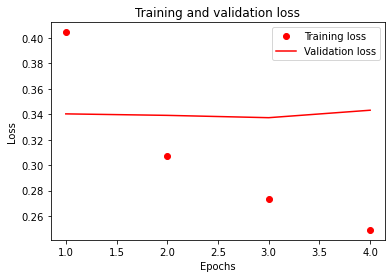

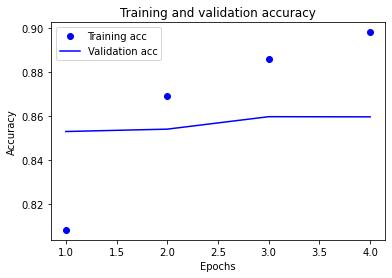

In [81]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

9)루브릭

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.

3가지 이상의 모델이 성공적으로 시도됨


2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함


3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

10) 회고

- 이번 프로젝트에서 **어려웠던 점**
NLP자체가 아직 전체적으로 어려운것 같다. 이해되는 부분이 많지 않다. 공부해야겠다.



- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**
트레인 어큐레시는 꾸준히 오르지만 벨리데이션이 떨어지는걸 보니 오버피팅이 의심되어 에폭을 줄여야했다.
아직 모델에 있어서 어떤 부분을 조정하고 어떤 형태인것인지 감이 없어 다양하게 바꿔보며 시도하고 있지만 여전히 이해된것같지 않다.


- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**
모델의 레이어 층들의 다양하게 값을 설정해보고, 배치사이즈를 조절해보았다. 배치사이즈가 높을수록 어큐레시가 낮았다.


- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**


- **자기 다짐**
서서히 구조적인 그림이 보이기 시작하지만 아직도 자세한 부분이나 숙달이 되지 않아 애로사항이 많다. 그래도 구글에 많은 자료가 있어 다행이다.!